### Carla tracks explorative data analysis

Main task of this notebook is to get a sense for the carla data.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.chdir('../..')
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

In [6]:
track_files = os.listdir(Path('carla/data') )
dfs = []
for file in track_files:
    df = pd.read_parquet(Path('carla/data') / file)
    df['file_name'] = file
    dfs.append(df)


In [7]:
tracks_df = pd.concat(dfs)

In [8]:
print(tracks_df.shape)
tracks_df.head(2)


(40000, 16)


,actor_id,actor_type,actor_speed_xyz,actor_acceleration_xyz,actor_location_xyz,actor_bbox,lane_id,road_id,light_state,timestamp,actor_heading_xyz,actor_speed,actor_acceleration,map,scene_id,file_name
0,176,vehicle.audi.etron,"[0.0, 0.0, -0.4899999797344208]","[0.0, 0.0, -9.799999237060547]","[405.71929931640625, -95.4216079711914, 0.2672...","[[-2.431448221206665, -1.0163798332214355, -0....",4,36,0,76.501362,"[0.010447029955685139, -0.9999454021453857, 0.0]",0.0,0.0,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet
1,175,vehicle.ford.ambulance,"[0.0, 0.0, -0.4899999797344208]","[0.0, 0.0, -9.799999237060547]","[105.29106140136719, -170.0607452392578, 0.585...","[[-3.471379518508911, -1.1736551523208618, -7....",-1,8,0,76.501362,"[0.9999830722808838, 0.005815246142446995, 0.0]",0.0,0.0,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet


In [9]:
tracks_df.groupby(['map', 'file_name']).size()

map                      file_name                 
Carla/Maps/Town01        scene_1_2025-02-24.parquet    10000
Carla/Maps/Town03        scene_2_2025-02-25.parquet    10000
Carla/Maps/Town04        scene_0_2025-02-23.parquet    10000
Carla/Maps/Town10HD_Opt  scene_3_2025-02-25.parquet    10000
dtype: int64

### High level learnings:

* hm, timestamps are not alligned, getting syncronous mode running would be great...
* road_id and lane_id seem to be ok


In [10]:
tracks_df.timestamp.value_counts()
tracks_df.road_id.value_counts()
tracks_df.actor_id.value_counts()

actor_id
168    1000
163    1000
169    1000
170    1000
171    1000
       ... 
113     500
112     500
111     500
110     500
109     500
Name: count, Length: 65, dtype: int64

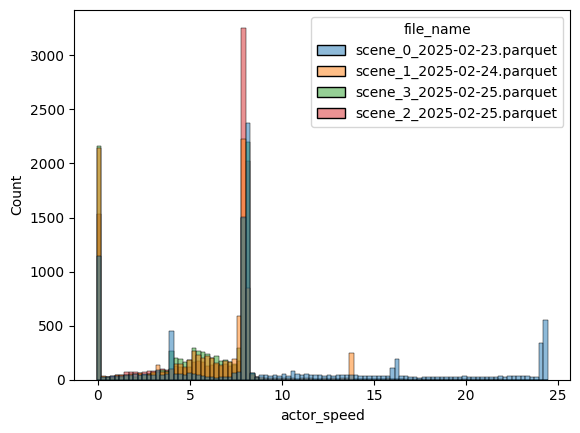

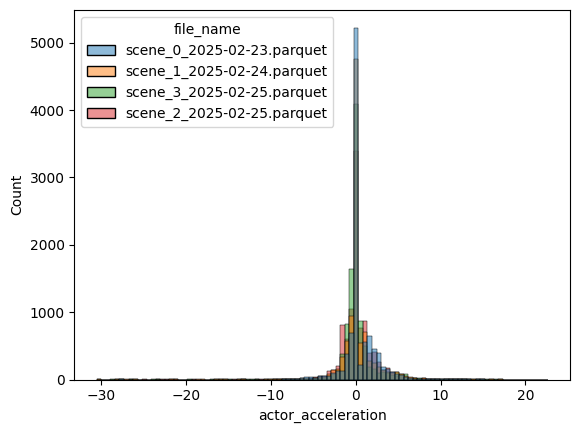

In [15]:
sns.histplot(data = tracks_df, x = 'actor_speed', bins=100, hue = 'file_name')
plt.show()
sns.histplot(data = tracks_df, x = 'actor_acceleration', bins=100, hue = 'file_name')
plt.show()

In [ ]:
#tracks_df.timestamp.round(1).value_counts()


In [ ]:
# unbox position values:

In [19]:
tracks_df['actor_location_x'] = tracks_df.actor_location_xyz.apply(lambda x: x[0])
tracks_df['actor_location_y'] = tracks_df.actor_location_xyz.apply(lambda x: x[1])
tracks_df['actor_location_z'] = tracks_df.actor_location_xyz.apply(lambda x: x[2])


In [ ]:
# pick a timestamp and filename and calculate distances:

In [20]:
tracks_df.head(2)

,actor_id,actor_type,actor_speed_xyz,actor_acceleration_xyz,actor_location_xyz,actor_bbox,lane_id,road_id,light_state,timestamp,actor_heading_xyz,actor_speed,actor_acceleration,map,scene_id,file_name,actor_location_x,actor_location_y,actor_location_z
0,176,vehicle.audi.etron,"[0.0, 0.0, -0.4899999797344208]","[0.0, 0.0, -9.799999237060547]","[405.71929931640625, -95.4216079711914, 0.2672...","[[-2.431448221206665, -1.0163798332214355, -0....",4,36,0,76.501362,"[0.010447029955685139, -0.9999454021453857, 0.0]",0.0,0.0,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,405.719299,-95.421608,0.267242
1,175,vehicle.ford.ambulance,"[0.0, 0.0, -0.4899999797344208]","[0.0, 0.0, -9.799999237060547]","[105.29106140136719, -170.0607452392578, 0.585...","[[-3.471379518508911, -1.1736551523208618, -7....",-1,8,0,76.501362,"[0.9999830722808838, 0.005815246142446995, 0.0]",0.0,0.0,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,105.291061,-170.060745,0.585300


In [34]:
i = 100

mask = (tracks_df.timestamp == tracks_df.timestamp.iloc[i]) &  (tracks_df.file_name == tracks_df.file_name.iloc[i])
mask.sum()
actor_id = tracks_df.actor_id.iloc[i]

In [26]:
tracks_df[mask][['actor_location_x', 'actor_location_y']]



,actor_location_x,actor_location_y
100,405.719299,-95.421608
101,105.291054,-170.060745
102,-4.062155,304.161560
103,-69.648575,37.353630
104,387.930725,-62.842342
105,211.311218,-307.879913
106,412.216370,-34.778954
107,181.269394,-374.956238
108,198.608475,-388.826233
109,160.558350,-392.639557


In [28]:
from scipy.spatial import distance

In [32]:
distance.pdist(tracks_df[mask][['actor_location_x', 'actor_location_y']])

array([309.5611919 , 572.35264329, 493.56243739,  37.11929309,
       287.9809603 ,  60.9896996 , 358.49319282, 359.13948209,
       385.28223475, 959.58519997, 327.0317683 , 102.84610896,
       431.3923211 , 967.47802934, 944.49936407, 498.03032724,
       488.41423368, 273.49968316, 569.02155428, 486.66715429,
       271.33852793, 302.29285423, 173.880414  , 335.41662552,
       218.52887919, 237.83708636, 229.33774522, 710.36537699,
       267.76093636, 313.59606715, 146.22875965, 728.00816524,
       692.5584307 , 256.87292874, 261.74270436, 187.87080506,
       492.8533882 , 274.75088717, 536.98257166, 648.83006632,
       536.81326515, 703.95224717, 722.01625   , 715.98303544,
       525.65078049, 741.28162571, 480.65805225, 593.62709492,
       510.92458414, 519.97360201, 308.31412753, 284.38829431,
       656.21432188,  16.90533165, 468.42080293, 445.11190146,
       487.23396261, 482.65852751, 503.5783159 , 487.73903769,
       466.15365767, 538.63423668, 439.68271513, 338.46

In [ ]:
# define 1 actor as the ego:

tracks_df[mask][['actor_location_x', 'actor_location_y']]

In [38]:
dist_threshold = 150
distance.cdist(tracks_df[mask & (tracks_df.actor_id == actor_id)][['actor_location_x', 'actor_location_y']], tracks_df[mask & (tracks_df.actor_id != actor_id)][['actor_location_x', 'actor_location_y']])


array([[309.5611919 , 572.35264329, 493.56243739,  37.11929309,
        287.9809603 ,  60.9896996 , 358.49319282, 359.13948209,
        385.28223475, 959.58519997, 327.0317683 , 102.84610896,
        431.3923211 , 967.47802934, 944.49936407, 498.03032724,
        488.41423368, 273.49968316, 569.02155428]])

In [36]:
#tracks_df.actor_id

tracks_df[mask & (tracks_df.actor_id == actor_id) ][['actor_location_x', 'actor_location_y']]

,actor_location_x,actor_location_y
100,405.719299,-95.421608


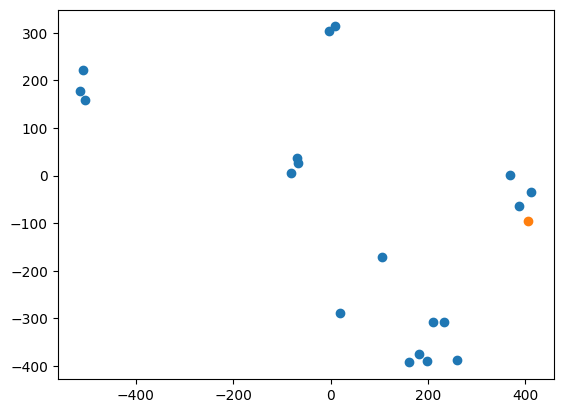

In [ ]:
plt.scatter(tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_y, label = 'OMV')
plt.scatter(tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_y, label = 'ego')
plt.show()

In [43]:
print(actor_id)
tracks_df[mask]


176


,actor_id,actor_type,actor_speed_xyz,actor_acceleration_xyz,actor_location_xyz,actor_bbox,lane_id,road_id,light_state,timestamp,actor_heading_xyz,actor_speed,actor_acceleration,map,scene_id,file_name,actor_location_x,actor_location_y,actor_location_z
100,176,vehicle.audi.etron,"[1.2349956080015545e-07, 2.7232562871404298e-0...","[1.0800138170452556e-06, 4.400132525006484e-07...","[405.71929931640625, -95.4216079711914, -0.028...","[[-2.431448221206665, -1.0163798332214355, -0....",4,36,0,76.751362,"[0.010447029955685139, -0.9999454021453857, 0.0]",-2.594087e-08,-4.287063e-07,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,405.719299,-95.421608,-0.028172
101,175,vehicle.ford.ambulance,"[3.507125438773073e-05, 3.494025122563471e-07,...","[-0.00010543866665102541, 2.3320683339989046e-...","[105.29105377197266, -170.0607452392578, 0.200...","[[-3.471379518508911, -1.1736551523208618, -7....",-1,8,0,76.751362,"[0.9999830722808838, 0.00581524521112442, -3.4...",8.879506e-05,-4.462284e-04,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,105.291054,-170.060745,0.200708
102,174,vehicle.dodge.charger_police_2020,"[-1.0603725542068787e-07, -2.55303955754016e-0...","[-1.0288777048117481e-06, 1.0561046792645357e-...","[-4.062154769897461, 304.16156005859375, -0.01...","[[-2.5092525482177734, -0.964883029460907, -0....",-3,145,0,76.751362,"[0.40026089549064636, -0.916401207447052, 0.0]",-1.904648e-08,-1.379635e-06,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,-4.062155,304.161560,-0.018774
103,173,vehicle.tesla.cybertruck,"[0.026259008795022964, 2.5850808015093207e-05,...","[-0.16495324671268463, -0.00038551297620870173...","[-69.64857482910156, 37.35363006591797, 9.8154...","[[-3.136775016784668, -1.194787621498108, -5.9...",2,1194,0,76.751362,"[0.9998528957366943, 0.0013419007882475853, 0....",-3.941006e-04,3.383942e-03,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,-69.648575,37.353630,9.815426
104,172,vehicle.lincoln.mkz_2017,"[1.9604166823228297e-07, -3.4549687555340824e-...","[4.572574653138872e-06, -6.288678378041368e-08...","[387.93072509765625, -62.842342376708984, 0.02...","[[-2.44679856300354, -1.064154028892517, -0.03...",-2,760,0,76.751362,"[-0.007663576398044825, 0.9999706149101257, 0.0]",-4.957248e-09,-9.792721e-08,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,387.930725,-62.842342,0.021047
105,171,vehicle.volkswagen.t2,"[0.011614082381129265, -0.0025287626776844263,...","[0.2322816550731659, -0.05057525262236595, 6.8...","[211.31121826171875, -307.8799133300781, 0.040...","[[-2.238895893096924, -1.0351985692977905, -0....",-1,149,0,76.751362,"[0.9999463558197021, 0.010283361189067364, -0....",1.418376e-02,2.233351e-01,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,211.311218,-307.879913,0.040953
106,170,vehicle.audi.a2,"[-7.031756467767991e-06, 0.000863189110532403,...","[0.00013628392480313778, -0.019708771258592606...","[412.21636962890625, -34.778953552246094, -0.0...","[[-1.852684497833252, -0.8939877152442932, 0.0...",6,37,0,76.751362,"[0.007663364987820387, -0.999970018863678, 0.0...",-1.444010e-03,3.334081e-02,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,412.216370,-34.778954,-0.038027
107,169,vehicle.toyota.prius,"[-2.3127654458221514e-07, 1.5624742388808954e-...","[6.764302270312328e-06, 1.5919067664071918e-06...","[181.26939392089844, -374.95623779296875, 0.00...","[[-2.2547717094421387, -1.0037736892700195, -0...",-1,42,0,76.751362,"[0.999971866607666, 0.007503484841436148, 1.78...",-8.231667e-07,2.263980e-05,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,181.269394,-374.956238,0.007444
108,168,vehicle.seat.leon,"[2.3589690201220037e-08, 9.801427225397674e-09...","[4.192675532976864e-06, -2.7829672035295516e-0...","[198.6084747314453, -388.82623291015625, -0.02...","[[-2.0965635776519775, -0.9096543192863464, 0....",4,266,0,76.751362,"[-0.999971866607666, -0.007503351662307978, 0.0]",-2.366257e-08,-3.983742e-06,Carla/Maps/Town04,0,scene_0_2025-02-23.parquet,198.608475,-388.826233,-0.024098
109,167,vehicle.harley-

In [45]:
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm

client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.get_world()



In [53]:
client.get_available_maps()
#os.getcwd()


['/Game/Carla/Maps/Town01',
 '/Game/Carla/Maps/Town10HD_Opt',
 '/Game/Carla/Maps/Town01_Opt',
 '/Game/Carla/Maps/Town02_Opt',
 '/Game/Carla/Maps/Town04',
 '/Game/Carla/Maps/Town03_Opt',
 '/Game/Carla/Maps/Town02',
 '/Game/Carla/Maps/Town04_Opt',
 '/Game/Carla/Maps/Town10HD',
 '/Game/Carla/Maps/Town05',
 '/Game/Carla/Maps/Town03',
 '/Game/Carla/Maps/Town05_Opt']

In [55]:
tracks_df[mask]['map'].iloc[0]

client.load_world('/Game/' + tracks_df[mask]['map'].iloc[0])


In [56]:
world_map = world.get_map()

In [65]:
xodr_map = world_map.to_opendrive()

with open("carla_map.xodr", "w") as file:
    file.write(xodr_map)

In [ ]:
#type(tmp)
#print(tmp)

import xml.etree.ElementTree as ET

# Load the OpenDRIVE XML
tree = ET.ElementTree(ET.fromstring(xodr_map))
root = tree.getroot()

# OpenDRIVE namespace
#namespace = {'xodr': 'http://www.opendrive.org'}

# Find all roads
roads = root.findall("road")
print(f"Total Roads Found: {len(roads)}")


Total Roads Found: 276


In [ ]:
roads = root.findall('road')
print(len(roads))
i = 10
roads[i].get('id')
print(roads[i].get('length'), roads[i].get('junction')) # no junction is -1


276
3.6320000000000022e+1 -1


In [96]:
roads[i].find('link').find('successor').get('elementId')
roads[i].find('link').find('predecessor').get('elementId')


'1452'

In [102]:
print(ET.tostring(roads[i], encoding = 'utf-8').decode('utf-8'))


<road id="10" junction="-1" length="3.6320000000000022e+1" name="Road 10">
        <link>
            <predecessor elementId="1452" elementType="junction" />
            <successor elementId="785" elementType="junction" />
        </link>
        <type s="0.0000000000000000e+0" type="town">
            <speed max="55" unit="mph" />
        </type>
        <planView>
            <geometry hdg="-5.6919527778103163e-3" length="3.6320000000000022e+1" s="0.0000000000000000e+0" x="2.1058669261610621e+2" y="1.7120793231290847e+2">
                <line />
            </geometry>
        </planView>
        <elevationProfile>
            <elevation a="1.9589233398437500e-1" b="0.0000000000000000e+0" c="0.0000000000000000e+0" d="0.0000000000000000e+0" s="0.0000000000000000e+0" />
        </elevationProfile>
        <lateralProfile>
            <superelevation a="0.0000000000000000e+0" b="0.0000000000000000e+0" c="0.0000000000000000e+0" d="0.0000000000000000e+0" s="0.0000000000000000e+0" />
    

In [68]:
# Extract road connections
road_connections = {}

for road in roads:
    road_id = road.get("id")
    
    link = road.find("link")
    if link is not None:
        successor = link.find("successor")
        predecessor = link.find("predecessor")

        successor_id = successor.get("elementId") if successor is not None else None
        predecessor_id = predecessor.get("elementId") if predecessor is not None else None

        road_connections[road_id] = {
            "successor": successor_id,
            "predecessor": predecessor_id
        }

# Print road connections
for road_id, links in road_connections.items():
    print(f"Road ID: {road_id} -> Successor: {links['successor']}, Predecessor: {links['predecessor']}")


Road ID: 0 -> Successor: 278, Predecessor: 148
Road ID: 1 -> Successor: 335, Predecessor: 278
Road ID: 2 -> Successor: 459, Predecessor: 335
Road ID: 3 -> Successor: 483, Predecessor: 459
Road ID: 4 -> Successor: 621, Predecessor: 483
Road ID: 5 -> Successor: 745, Predecessor: 621
Road ID: 6 -> Successor: 45, Predecessor: 41
Road ID: 7 -> Successor: 1197, Predecessor: 890
Road ID: 8 -> Successor: 1103, Predecessor: 1197
Road ID: 9 -> Successor: 1452, Predecessor: 1103
Road ID: 10 -> Successor: 785, Predecessor: 1452
Road ID: 11 -> Successor: 483, Predecessor: 785
Road ID: 12 -> Successor: 870, Predecessor: 483
Road ID: 13 -> Successor: 1249, Predecessor: 870
Road ID: 14 -> Successor: 850, Predecessor: 1249
Road ID: 15 -> Successor: 148, Predecessor: 255
Road ID: 16 -> Successor: 916, Predecessor: 148
Road ID: 17 -> Successor: 1452, Predecessor: 916
Road ID: 18 -> Successor: 1008, Predecessor: 1452
Road ID: 19 -> Successor: 621, Predecessor: 1008
Road ID: 20 -> Successor: 32, Predecesso

In [75]:
#tracks_df[mask]


In [69]:
from shapely.geometry import Polygon, LineString

In [72]:
carla_map = world.get_map()
waypoints = carla_map.generate_waypoints(0.50)

# Store road polygons
road_polygons = []

# Process each waypoint to extract boundaries
for waypoint in waypoints:
    # Get left and right lane markings
    left_marking = waypoint.get_left_lane()
    right_marking = waypoint.get_right_lane()

    if left_marking and right_marking:
        # Extract boundary points
        left_x, left_y = left_marking.transform.location.x, left_marking.transform.location.y
        right_x, right_y = right_marking.transform.location.x, right_marking.transform.location.y

        # Create polygon for road segment
        road_polygon = Polygon([
            (waypoint.transform.location.x, waypoint.transform.location.y),  # Center
            (left_x, left_y),  # Left boundary
            (right_x, right_y)  # Right boundary
        ])

        road_polygons.append(road_polygon)

print(f"Total road polygons created: {len(road_polygons)}")

Total road polygons created: 59247


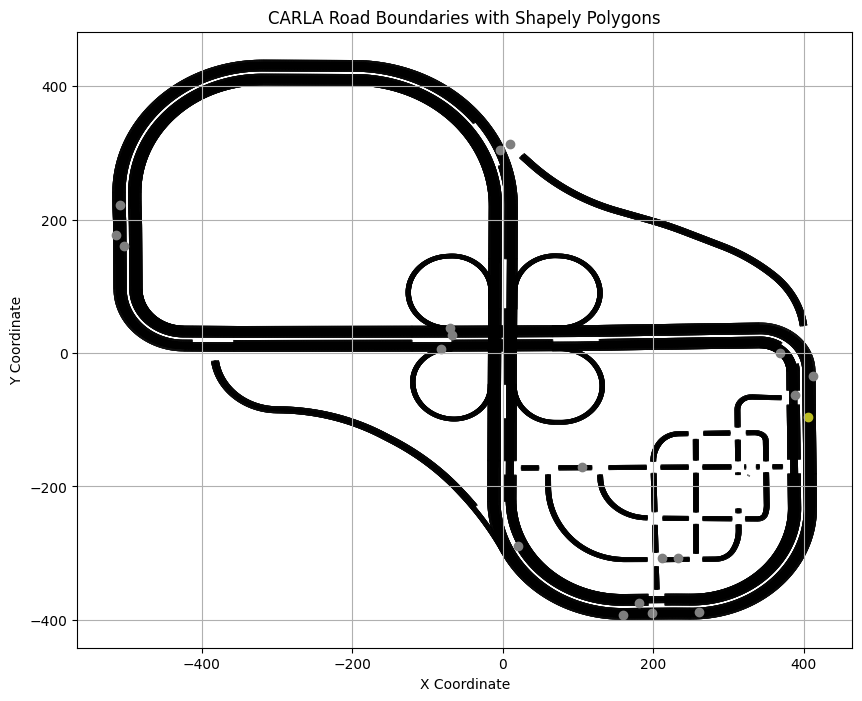

In [76]:
# Plot the road polygons
plt.figure(figsize=(10, 8))

for polygon in road_polygons:
    x, y = polygon.exterior.xy  # Get polygon boundary
    plt.fill(x, y, alpha=0.5, edgecolor="black")

plt.scatter(tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id != actor_id)].actor_location_y, label = 'OMV')
plt.scatter(tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_x, tracks_df[mask & (tracks_df.actor_id == actor_id)].actor_location_y, label = 'ego')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("CARLA Road Boundaries with Shapely Polygons")
plt.grid(True)
plt.show()